In [99]:
%load_ext autoreload
%autoreload 2

import numpy as numpy
import torch
import matplotlib.pyplot as plt

from cre_reg.optimization import optimize_weights, expectation_maximization_weights
from cre_reg.negative_log_likelihood import eval_naive_log_Pij, evaluate_nll
from cre_reg.experiments.two_gaussian_mixture import TwoGaussianModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate the Data

In [100]:
# Parameters for the dataset
n_images = 100000
num_structures = 41
noise_stdev = 1.0
num_epochs = 1000

In [101]:
# Generate the images
tgm = TwoGaussianModel()
noiseless_images = tgm.sample(n_images).to(device)
images = noiseless_images + noise_stdev * torch.randn_like(noiseless_images)


Plot the data to see the effect of the noise.

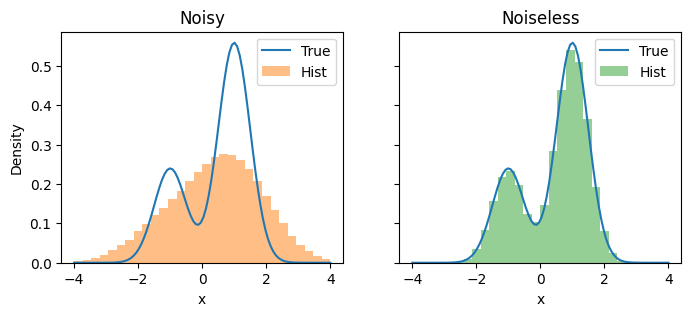

In [102]:

# Functional form of the Boltzmann Density for Reference.
xax = torch.linspace(-4, 4, 100)
pi = tgm.evaluate_boltzmann(xax)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
nbins = 30
for ax in axes:
    ax.plot(xax, pi, label='True', c='C0')

axes[0].hist(images.cpu().numpy(), bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')
axes[1].hist(noiseless_images.cpu().numpy(), bins=nbins, range=(-4, 4), 
             color="C2", density=True, alpha=0.5, label='Hist')

for ax in axes:
    ax.set_xlabel('x')
    ax.legend()
axes[0].set_title('Noisy')
axes[1].set_title('Noiseless')
axes[0].set_ylabel('Density')
plt.show()


# Construct the structures and evaluate the log-likelihood pairs.

In [103]:
# Evently spaced clusters:
x = torch.linspace(-4, 4, num_structures, device=device)
negative_log_weights = torch.randn_like(x) * 0.01 # Random initial weights
cluster_sizes = torch.ones_like(negative_log_weights)

distance_matrix = (images.unsqueeze(1) - x.unsqueeze(0))**2
log_Pij = eval_naive_log_Pij(distance_matrix, noise_stdev)
print(log_Pij.shape)

torch.Size([100000, 41])


# Perform expectation maximization updates


In [104]:
log_weights = torch.randn_like(x) * 0.01 # Random initial weights
loss = []

num_iterations = 500
log_weights, loss =  expectation_maximization_weights(log_Pij, log_weights, num_iterations)


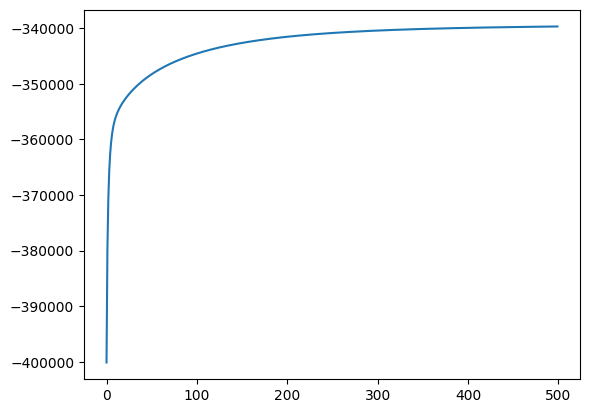

In [105]:
plt.plot(loss)

In [106]:
optimized_boltzmann = torch.exp(log_weights)
optimized_boltzmann /= optimized_boltzmann.sum() * (x[1] - x[0]) 


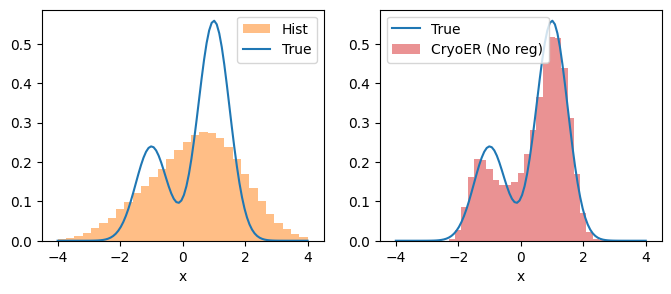

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

dx = (x[1] - x[0]).cpu().numpy()


axes[0].hist(images.cpu().numpy(), bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')

axes[1].bar(x.cpu(), optimized_boltzmann.detach().cpu().numpy(), 
    width=dx, label='CryoER (No reg)', color="C3", alpha=0.5)
# axes[1].plot(x.cpu(), optimized_boltzmann.detach().cpu().numpy(), label='CryoER (No reg)', color="C3")

for ax in axes:
    ax.plot(xax, pi, label='True', c='C0')
    ax.set_xlabel('x')
    ax.legend()
plt.legend()
# print(optimized_log_weight_no_reg)

## Perform the optimization with no nontrivial regularization.

In [108]:
loss_fxn = lambda negative_log_weights: evaluate_nll(negative_log_weights, log_Pij)
# Anchors the average log weight to be zero to keep it drifting off to inf, -inf
regularization_fxn = anchor_regularization 

optimized_negative_log_weight_no_reg, losses_no_reg = optimize_weights(
    log_Pij, loss_fxn, log_weights_init=negative_log_weights, 
    cluster_sizes=cluster_sizes, regularization_fxn=regularization_fxn,
    num_epochs=num_epochs,
    )


100%|██████████| 1000/1000 [00:07<00:00, 140.75it/s]


Text(0.5, 1.0, 'Loss (No Regularization)')

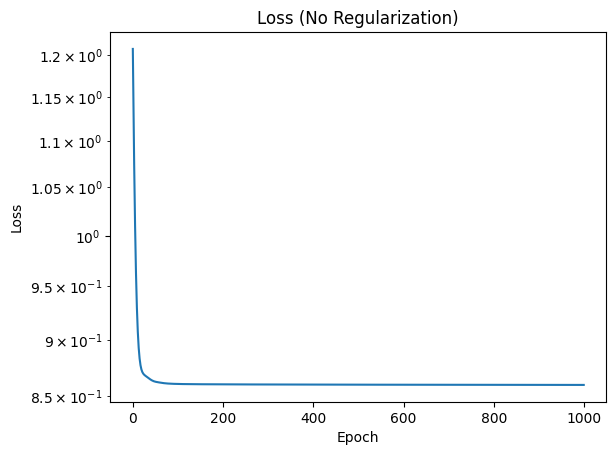

In [109]:
fig = plt.figure()
plt.semilogy(losses_no_reg.numpy())
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss (No Regularization)")

In [110]:
optimized_boltzmann = torch.exp(-optimized_negative_log_weight_no_reg)
optimized_boltzmann /= optimized_boltzmann.sum() * (x[1] - x[0]) 

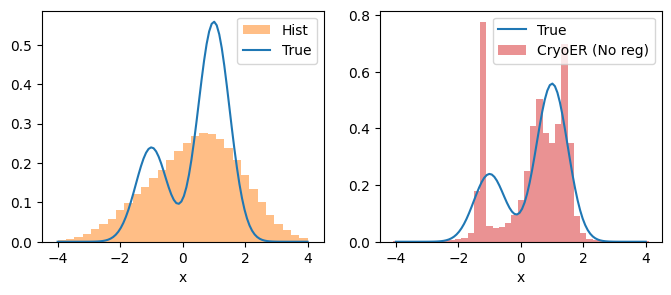

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

dx = (x[1] - x[0]).cpu().numpy()


axes[0].hist(images.cpu().numpy(), bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')

axes[1].bar(x.cpu(), optimized_boltzmann.detach().cpu().numpy(), 
    width=dx, label='CryoER (No reg)', color="C3", alpha=0.5)
# axes[1].plot(x.cpu(), optimized_boltzmann.detach().cpu().numpy(), label='CryoER (No reg)', color="C3")

for ax in axes:
    ax.plot(xax, pi, label='True', c='C0')
    ax.set_xlabel('x')
    ax.legend()
plt.legend()
# print(optimized_log_weight_no_reg)